<a href="https://colab.research.google.com/github/EdH66/CMAP-Analysis/blob/main/MPO_automatic_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multiparameter optimisation (MPO) calculator

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Read the CSV file
import pandas as pd

path_6k_curated = '/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/Chembl_P2_Cp_6K_curated.csv'
df_6k_curated = pd.read_csv(path_6k_curated)
numeric_columns = ['logp', 'TSA', 'mw', 'HBD', 'HBA', 'C_Basic pKa', 'Clogd']  # Add or remove column names as needed
df_6k_curated[numeric_columns] = df_6k_curated[numeric_columns].apply(pd.to_numeric, errors='coerce')

path_chemical_MPO = '/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/MPO_validationset.csv'
chemical_MPO = pd.read_csv(path_chemical_MPO)

print(chemical_MPO.head)



<bound method NDFrame.head of             Drug  MPO      mw  logp   TSA  logd  HBD  basic pka
0     Alprazolam  6.0  309.00  2.60  43.0  1.90  0.0        2.4
1     Aniracetam  6.0  219.00  0.70  47.0  1.30  0.0        1.0
2       Caffeine  6.0  194.00  0.00  62.0 -0.60  0.0        1.0
3       Zaleplon  6.0  305.00  1.40  74.0  1.40  0.0        1.0
4     Flumazenil  5.9  303.00  1.30  64.0  2.20  0.0        1.0
..           ...  ...     ...   ...   ...   ...  ...        ...
145  Peptide 20   NaN     NaN   NaN   NaN   NaN  NaN        NaN
146    PDK4-IN-1  NaN     NaN   NaN   NaN   NaN  NaN        NaN
147    Berberine  NaN  336.37 -1.28  40.8 -1.28  0.0        NaN
148   Infliximab  NaN     NaN   NaN   NaN   NaN  NaN        NaN
149    Auranofin  NaN  678.49   NaN   NaN   NaN  NaN        NaN

[150 rows x 8 columns]>


## LogP function

In [23]:
def normalize_logP(value):
    if value < 3:
        return 1
    elif 3 <= value < 5:
        return 1 - (value - 3) / 2  # Ramp from 1 to 0 over the range 3 to 5
    else:
        return 0

# Assuming df is your DataFrame and 'LogP' is the column name
chemical_MPO['Normalized_LogP'] = chemical_MPO['logp'].apply(normalize_logP)
df_6k_curated['Normalized_LogP'] = df_6k_curated['logp'].apply(normalize_logP)


## LogD function

In [25]:
def normalize_logD(value):
    if value < 2:
        return 1
    elif 2 <= value < 4:
        return 1 - (value - 2) / 2  # Ramp from 1 to 0 over the range 2 to 4
    else:
        return 0

chemical_MPO['Normalized_LogD'] = chemical_MPO['logd'].apply(normalize_logD)
df_6k_curated['Normalized_CLogD'] = df_6k_curated['Clogd'].apply(normalize_logP)


## Molecular weight function

In [26]:
def normalize_mol_weight(value):
    if value < 360:
        return 1
    elif 360 <= value < 500:
        return 1 - (value - 360) / 140  # Ramp from 1 to 0 over the range 360 to 500
    else:
        return 0

chemical_MPO['Normalized_Mol_Weight'] = chemical_MPO['mw'].apply(normalize_mol_weight)
df_6k_curated['Normalized_Mol_Weight'] = df_6k_curated['mw'].apply(normalize_mol_weight)


#Topological Surface Area function

In [27]:
def normalize_TPSA(value):
    if value < 20:
        return 0
    elif 20 <= value < 40:
        return (value - 20) / 20  # Ramp from 0 to 1 over the range 20 to 40
    elif 40 <= value <= 90:
        return 1
    elif 90 < value <= 120:
        return 1 - (value - 90) / 30  # Ramp from 1 to 0 over the range 90 to 120
    else:
        return 0

chemical_MPO['Normalized_TPSA'] = chemical_MPO['TSA'].apply(normalize_TPSA)
df_6k_curated['Normalized_TSA'] = df_6k_curated['TSA'].apply(normalize_TPSA)



#h-bond donor function

In [28]:
def normalize_hbond_donor(value):
    if value == 0:
        return 1
    elif value == 1:
        return 0.75
    elif value == 2:
        return 0.5
    elif value == 3:
        return 0.25
    else:
        return 0

chemical_MPO['Normalized_Hbond_Donor'] = chemical_MPO['HBD'].apply(normalize_hbond_donor)
df_6k_curated['Normalized_Hbond_Donor'] = df_6k_curated['HBD'].apply(normalize_hbond_donor)

# basic pKA function

In [44]:
def normalize_pKa(value):
    if value < 8:
        return 1
    elif 8 <= value < 10:
        # Linear decrease from 1 to 0 over the range of 8 to 10
        return 1 - (value - 8) / 2
    else:
        return 0

chemical_MPO['Normalized_Most_Basic_pKa'] = chemical_MPO['basic pka'].apply(normalize_pKa)
df_6k_curated['Normalized_Most_C_Basic pKa'] = df_6k_curated['C_Basic pKa'].apply(normalize_pKa)


<ipython-input-44-4e95bae6ee63>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_MPO['Normalized_Most_Basic_pKa'] = chemical_MPO['basic pka'].apply(normalize_pKa)


#Calculate Validation MPO Score

In [43]:
import pandas as pd

# Find all columns that contain 'Normalized' in their title
normalized_cols = [col for col in chemical_MPO.columns if 'Normalized' in col]

# Create 'Calculated_MPO' column by summing normalized values
chemical_MPO['Calculated_MPO'] = chemical_MPO[normalized_cols].sum(axis=1)

# Move 'Calculated_MPO' to the beginning
columns = ['Calculated_MPO'] + [col for col in chemical_MPO.columns if col != 'Calculated_MPO']

# Reorder the DataFrame columns
chemical_MPO = chemical_MPO[columns]

# Add 'Good_Flag' column
chemical_MPO['Good_Flag'] = chemical_MPO.apply(lambda x: 'Good' if abs(x['Calculated_MPO'] - x['MPO']) <= 0.25 else '', axis=1)




<ipython-input-43-14e80f609d29>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemical_MPO['Good_Flag'] = chemical_MPO.apply(lambda x: 'Good' if abs(x['Calculated_MPO'] - x['MPO']) <= 0.25 else '', axis=1)


Calculate novel MPO Scores

In [52]:
import pandas as pd

# Define a custom function to calculate Calculated_MPO for each row
def calculate_calculated_mpo(row):
    # Check if all columns in the row are not NaN
    if not row[normalized_cols_6k].isnull().any():
        return row[normalized_cols_6k].sum()
    else:
        return None

# Calculate the initial number of rows
initial_row_count = len(df_6k_curated)

# Apply the custom function row-wise to calculate Calculated_MPO
df_6k_curated['Calculated_MPO'] = df_6k_curated.apply(calculate_calculated_mpo, axis=1)

# Define the numeric columns you want to filter on
numeric_columns = ['logp', 'TSA', 'mw', 'HBD', 'HBA', 'C_Basic pKa', 'Clogd']

# Filter rows that have NaN values in any of the specified numeric columns
df_6k_curated = df_6k_curated.dropna(subset=numeric_columns)

# Calculate the number of rows removed
rows_removed = initial_row_count - len(df_6k_curated)

# Move 'Calculated_MPO' to the beginning in df_6k_curated
columns_6k = ['Calculated_MPO'] + [col for col in df_6k_curated.columns if col != 'Calculated_MPO']

# Reorder the DataFrame columns for df_6k_curated
df_6k_curated = df_6k_curated[columns_6k]

# Count the number of rows with and without a Calculated_MPO score
count_with_score = df_6k_curated['Calculated_MPO'].notnull().sum()
count_without_score = df_6k_curated['Calculated_MPO'].isnull().sum()

# Print the counts and the number of rows removed
print("Number of rows with a Calculated_MPO score:", count_with_score)
print("Number of rows without a Calculated_MPO score:", count_without_score)
print("Number of rows removed during filtering:", rows_removed)

# Define df_6k_curated_sorted as an empty DataFrame
df_6k_curated_sorted = pd.DataFrame()

# Sort the DataFrame by 'Calculated_MPO' in descending order
df_6k_curated_sorted = df_6k_curated.sort_values(by='Calculated_MPO', ascending=False, na_position='last')

# Display the first 15 rows of the sorted DataFrame
print(df_6k_curated_sorted.head(15))

# Export df_6k_curated to a CSV file
df_6k_curated.to_csv('/content/drive/My Drive/Colab Notebooks/CMAP Drug Prediction/df_6k_curated_withMPO.csv', index=False)



Number of rows with a Calculated_MPO score: 3744
Number of rows without a Calculated_MPO score: 0
Number of rows removed during filtering: 0
      Calculated_MPO      ChEMBL ID                       Name  Phase      mw  \
6168             6.0      CHEMBL934                 METYRAPONE      4  226.28   
3798             6.0  CHEMBL2105161                  NICOBOXIL      3  223.27   
2502             6.0      CHEMBL681                  ETOMIDATE      4  244.29   
1777             6.0      CHEMBL407                 FLUMAZENIL      4  303.29   
4474             6.0   CHEMBL136800                      CX516      2  241.29   
4343             6.0   CHEMBL435966                 NIMORAZOLE      4  226.24   
1780             6.0  CHEMBL3608680               FEZOLINETANT      3  358.40   
555              6.0   CHEMBL284092                   GEPIRONE      2  359.47   
3050             6.0    CHEMBL13280              FLUNITRAZEPAM      4  313.29   
2713             6.0  CHEMBL4297331              

#Displaying the result

In [45]:
# Sort the DataFrame by 'Calculated_MPO' in descending order
chemical_MPO_sorted = chemical_MPO.sort_values(by='Calculated_MPO', ascending=False, na_position='last')

# Display the first 25 rows of the sorted DataFrame
print(chemical_MPO_sorted.head(15))



     Calculated_MPO           Drug  MPO      mw  logp    TSA  logd  HBD  \
0          6.000000     Alprazolam  6.0  309.00  2.60  43.00  1.90  0.0   
3          6.000000       Zaleplon  6.0  305.00  1.40  74.00  1.40  0.0   
1          6.000000     Aniracetam  6.0  219.00  0.70  47.00  1.30  0.0   
2          6.000000       Caffeine  6.0  194.00  0.00  62.00 -0.60  0.0   
4          5.900000     Flumazenil  5.9  303.00  1.30  64.00  2.20  0.0   
5          5.885714   Remifentanil  5.9  376.00  2.00  76.00  1.80  0.0   
6          5.814286      Buspirone  5.8  386.00  2.20  70.00  1.20  0.0   
7          5.750000   Ethosuximide  5.8  141.00  0.40  46.00  0.20  1.0   
8          5.750000    Galantamine  5.8  287.00  1.00  42.00 -0.70  1.0   
9          5.750000    Moclobemide  5.8  269.00  2.20  42.00  1.30  1.0   
10         5.750000      Oxycodone  5.8  315.00  0.00  59.00  1.10  1.0   
11         5.750000     Thiopental  5.8  242.00  1.80  59.00 -0.90  1.0   
13         5.700000    Hy

Drugs that were not calculated

In [47]:
!pip install seaborn

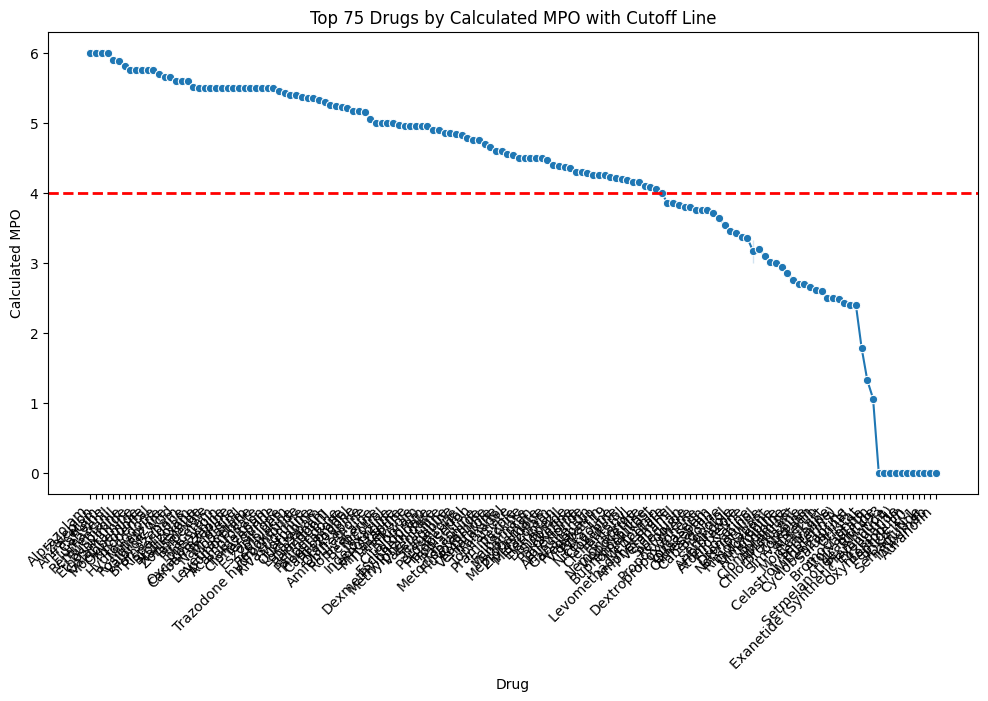

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 150 rows
top_150 = chemical_MPO_sorted.head(150)

# Create a line plot with dots for the top 25 calculated MPO values
plt.figure(figsize=(12, 6))
sns.lineplot(x=top_150['Drug'], y=top_150['Calculated_MPO'], marker='o')

# Add a horizontal dotted red line as a cutoff at 4.0
plt.axhline(4.0, color='red', linestyle='--', linewidth=2)

# Improve the plot aesthetics
plt.xticks(rotation=45, ha='right')  # Rotate the drug names for readability
plt.xlabel('Drug')
plt.ylabel('Calculated MPO')
plt.title('Top 75 Drugs by Calculated MPO with Cutoff Line')
plt.grid(False)

# Display the plot
plt.show()
